In [86]:
# import sys
# sys.path.append('/home/jodie/miniconda3/lib/python3.9/site-packages')
# print(sys.executable) -> /usr/bin/python3
# # /usr/bin/python3 -m pip install scanpy

import scanpy as sc
import pandas as pd
import numpy as np
import igraph
import leidenalg
import loompy 
import anndata
from sklearn.metrics import adjusted_rand_score

f1 = '/scratch1/jodie/wolbachia/Dmelanogaster_wMel_RNAseq/01_09_23_Azenta/GeneExpressionStudy/count_files/01_09_23_Azenta_normalized.csv.gz'
fca_all = '/storage1/jodie/anndata/h5ad/stringent/s_fca_biohub_all_wo_blood_10x.h5ad' #stringent body loom file from Fly Cell Atlas, Downloaded 7/20/23
fca_body = '/storage1/jodie/anndata/h5ad/stringent/s_fca_biohub_body_10x.h5ad'
fca_ovary = '/storage1/jodie/anndata/h5ad/stringent/s_fca_biohub_ovary_10x.h5ad'
f3 = '/scratch1/jodie/wolbachia/Dmelanogaster_wMel_RNAseq/01_09_23_Azenta/GeneExpressionStudy/count_files/05_31_2023_concat_normalized.csv.gz'

r1 = '/storage1/jodie/anndata/scanpy_results/azenta-01_09_23.h5ad'
r2 = '/storage1/jodie/anndata/scanpy_results/fca_all.h5ad'

sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')

-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                 9.0.1
apport_python_hook  NA
argcomplete         NA
asttokens           NA
backcall            0.2.0
colorama            0.4.4
comm                0.1.3
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           4.4.2
executing           1.2.0
google              NA
h5py                3.8.0
igraph              0.10.4
ipykernel           6.22.0
jedi                0.18.2
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.1
llvmlite            0.40.0
loompy              3.0.7
matplotlib          3.7.1
matplotlib_inline   0.1.6
mpl_toolkits        NA
natsort             8.3.1
netifaces           0.11.0
numba               0.57.0
numpy               1.21.5
numpy_groupies      0.9.20
packaging           23.1
pandas              2.0.1
parso               0.8.3
patsy               0.5.3
pexpect             4.8.0
pickleshare         0.7.5


In [87]:
'''
Parse bulk File and Create adata object 
'''
def sc_parse(file, sep):
    '''
    Function Parses a gene expression count matrix an outputs an AnnData object using scanpy
    Input: Normalized Gene Expression Count Matrix 
    Output: adata scanpy object 
    '''
    #import file to pandas dataframe, rename first column to 'Gene'
    X = pd.read_csv(file, sep=sep)
    X.rename(columns = {X.columns[0]:'Gene'}, inplace = True)
    
    #Extract Column and Row names 
    Gene = X['Gene']
    CellID = X.columns[1:]
    tissue = []
    for id in CellID:
        tissue.append(id.split('-')[0])

    #Export Values to numpy dataframe as float
    df = X.drop(columns=['Gene']).to_numpy().astype(float)
    dft = df.T

    # Create a new AnnData object
    adata = sc.AnnData(X=dft, 
                       dtype = df.dtype)
    
    # Set the cell IDs as observation names
    adata.obs_names = CellID
    adata.obs['tissue'] = tissue
    adata.obs['Sample'] = CellID
    adata.var_names = Gene

    #make all names and variables unique
    adata.var_names_make_unique()
    adata.obs_names_make_unique()

    # Set the gene IDs as variable names
    return adata

def filter_anndata(adata, results):
    #filter out poor quality cells
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)

    #mt genes:
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# 
    # #noramlize the counts
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    #highly variable genes:
    # sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, flavor='cell_ranger')
    adata.raw = adata

    #filter for variable genes:
    # adata = adata[:, adata.var.highly_variable]
    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
    sc.pp.scale(adata, max_value=10)
    adata.write(results)
    return adata

def pca_anndata(adata, results):
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca(adata, color = "tissue", size=25, alpha = 0.5)
    sc.pl.pca_variance_ratio(adata, log=True)
    adata.write(results)
    return adata

adata_05_31_23 = sc_parse(f3, ',')
adata_05_31_23 




AnnData object with n_obs × n_vars = 44 × 12419
    obs: 'tissue', 'Sample'

In [88]:
'''
Computing the neiborhood map for adata object 
'''
def neighbors_rank(adata, results):
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.leiden(adata)
    sc.tl.paga(adata)
    sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
    sc.tl.umap(adata, init_pos='paga')
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=["leiden",'tissue'], size = 25, alpha = 0.5)

    #find marker genes
    sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
    sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

    sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
    sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

    adata.write(results)
    return adata


In [89]:

def sc_parse_h5ad(file):
    
    '''
    Function Parses a h5ad file containg gene expession information an outputs an AnnData object using scanpy
    Input: Normalized Gene Expression Count Matrix 
    Output: adata scanpy object 
    '''
    #import file to pandas dataframe, rename first column to 'Gene'
    adata_raw= sc.read_h5ad(file) 

    X = adata_raw.X #row are samples, columns are genes
    
    #Extract Column and Row names 

    annotation = list(adata_raw.obs.annotation_broad_extrapolated)
    CellID= list(adata_raw.obs.index)
    tissue =list(adata_raw.obs.tissue)
    Gene = list(adata_raw.var.n_cells.index)

    # Create a new AnnData object
    adata = sc.AnnData(X=X, dtype = X.dtype)
    
    # Set the cell IDs as observation names
    adata.obs_names = CellID
    adata.obs['tissue'] = tissue
    adata.obs['annotation'] = annotation
    adata.obs['Sample'] = CellID
    adata.var_names = Gene

    #make all names and variables unique
    adata.var_names_make_unique()
    adata.obs_names_make_unique()

    # Set the gene IDs as variable names
    return adata

adata_ref = sc_parse_h5ad(fca_all)
# adata_ref = sc.read_h5ad(fca_all)

In [92]:
adata_concat
sc.pp.regress_out(adata_concat, ['total_counts', 'pct_counts_mt'])

ValueError: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.

In [90]:
adata_concat = anndata.concat([adata_05_31_23, adata_ref], join = "inner")

adata_concat_filtered = filter_anndata(adata_concat, "/storage1/jodie/anndata/scanpy_results/05_31_2023_FCA-filter.h5ad")
adata_concat_pca = pca_anndata(adata_concat_filtered,  "/storage1/jodie/anndata/scanpy_results/05_31_2023_FCA-pca.h5ad")
adata_concat_nn = neighbors_rank(adata_concat_filtered, "/storage1/jodie/anndata/scanpy_results/05_31_2023_FCA-nn.h5ad")

/home/jodie/.local/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
/home/jodie/.local/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


ValueError: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.

In [ ]:
#rank genes by clustering 

adata = sc.read(r1)
top_genes =pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

# neighbors_rank(adata_05_31_23, "anndata/05_31_2023_nn.h5ad")
adata_05_31_23 = sc.read("anndata/05_31_2023_nn.h5ad")
top_genes =pd.DataFrame(adata_05_31_23.uns['rank_genes_groups']['names']).head(5)
result = adata_05_31_23.uns['rank_genes_groups']
groups = result['names'].dtype.names



In [ ]:
adata_ref.write("anndata/noramlized_fca.h5ad", compression="gzip")

In [ ]:
adata = sc.read("anndata/05_31_2023_nn.h5ad")
adata_ref = sc.read("anndata/noramlized_fca.h5ad")
adata.write_loom("anndata/05_31_2023.loom", write_obsm_varm=False)

# print(adata,adata_ref)

#To use sc.tl.ingest, the datasets need to be defined on the same variables.
var_names = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]

sc.tl.ingest(adata, adata_ref, obs='leiden')
adata.uns['leiden_colors'] = adata_ref.uns['leiden_colors']  # fix colors
# sc.pl.umap(adata, color='leiden', wspace=0.5)



adata_concat.obs.leiden = adata_concat.obs.leiden.astype('category')

# print(adata_concat.obs.leiden.cat)

adata_concat.uns['leiden_colors'] = adata_ref.uns['leiden_colors']  # fix category colors
adata_concat.write("anndata/05_31_2023-FCA_concat.h5ad")

sc.pl.umap(adata_concat, color=['batch','tissue'])





NameError: name 'sc' is not defined

/home/jodie/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jodie/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


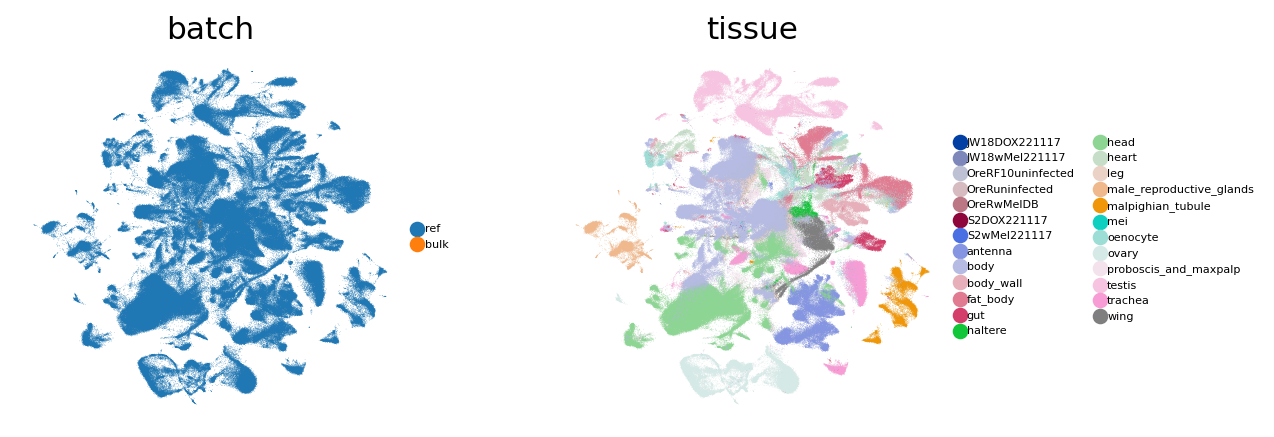

AAACCCAAGTCTAACC-0ece9e7a__FCA53_Male_oenocyteGFP_adult_5dWT_Jasper_sample1-ref        oenocyte
AAACCCACAAGCGGAT-0ece9e7a__FCA53_Male_oenocyteGFP_adult_5dWT_Jasper_sample1-ref        oenocyte
AAACCCACAATGAAAC-0ece9e7a__FCA53_Male_oenocyteGFP_adult_5dWT_Jasper_sample1-ref        oenocyte
AAACCCACAGGCTATT-0ece9e7a__FCA53_Male_oenocyteGFP_adult_5dWT_Jasper_sample1-ref        oenocyte
AAACCCACATACGCAT-0ece9e7a__FCA53_Male_oenocyteGFP_adult_5dWT_Jasper_sample1-ref        oenocyte
                                                                                       ...     
S2DOX221117-6-bulk                                                                  S2DOX221117
S2wMel221117-1-bulk                                                                S2wMel221117
S2wMel221117-2-bulk                                                                S2wMel221117
S2wMel221117-4-bulk                                                                S2wMel221117
S2wMel221117-6-bulk                     

In [ ]:
adata_concat=sc.read("anndata/05_31_2023-FCA_concat.h5ad")

sc.pl.umap(adata_concat,
           color=['batch','tissue'],
           sort_order=True,
        #    legend_loc='on data',
           legend_fontsize = 5,
           legend_fontweight = 'normal',
         #   groups = ['bulk','JW18wMel221117', 'JW18DOX221117','S2wMel221117','S2DOX221117'],
           na_in_legend = False)

adata_concat.obs.tissue

/home/jodie/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


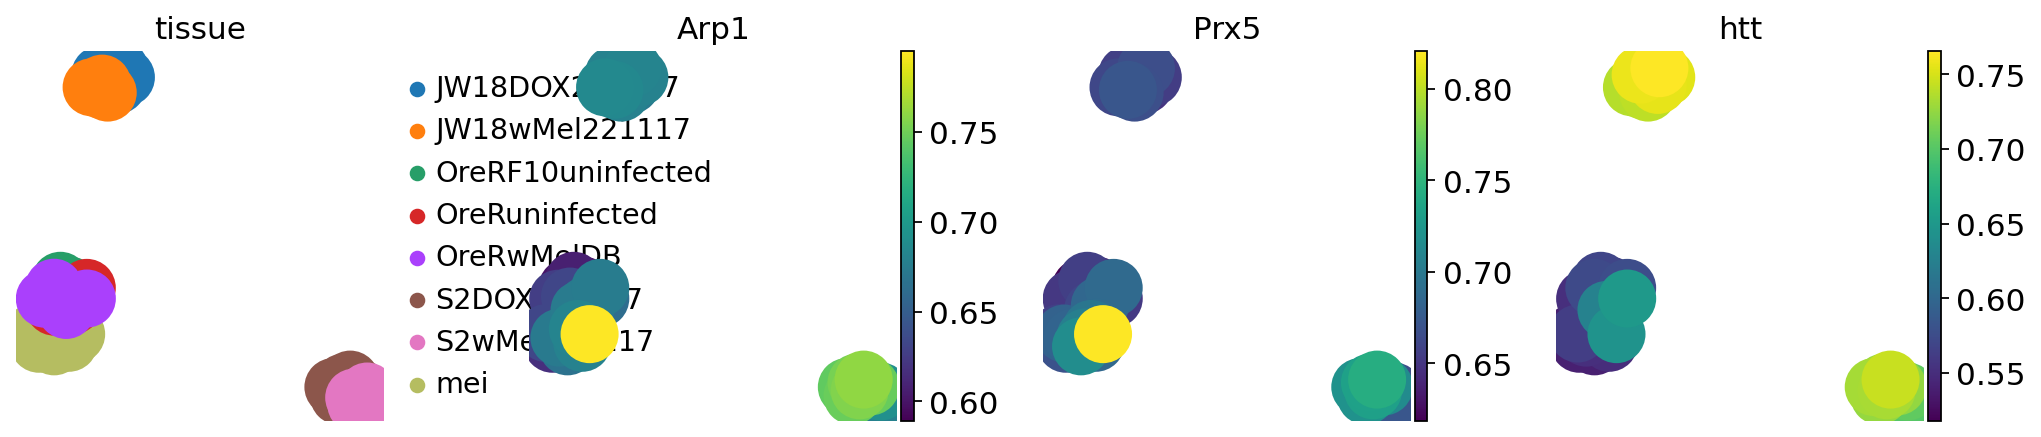

AnnData object with n_obs × n_vars = 44 × 12419
    obs: 'tissue', 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
adata = sc.read("anndata/05_31_2023_nn.h5ad")

sc.pl.umap(adata, color=["tissue",'Arp1',"Prx5","htt"])

adata